In [ ]:
# NANDHU SREEDEVI KUMAR
# 1. Install RDKit (Chemical processing library)
!pip install -q rdkit

# 2. Download Tox21 Dataset (from DeepChem source)
!wget -q https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz
!gunzip -f tox21.csv.gz


In [ ]:
# STEP 1: INSTALLATIONS & DATA LOADING
import pandas as pd
import numpy as np
import torch
import os
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")


#FEATURE EXTRACTION PIPELINE
FEATURE_NAMES = [
    'MolWt',           # Molecular Weight
    'MolLogP',         # Solubility
    'TPSA',            # Polar Surface Area
    'RingCount',       # Total Rings
    'NumRotatableBonds',
    'NumHDonors',
    'NumHAcceptors',
    'NumAromaticRings',
    'FractionCSP3',    # 3D complexity
    'HeavyAtomCount',
    'QED',             # Drug-likeness
    'BertzCT'          # Molecular Complexity (New addition for better uniqueness)
]

def get_mol_descriptors(smiles):
    if pd.isna(smiles): return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None

    try:
        features = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.TPSA(mol),
            Descriptors.RingCount(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumAromaticRings(mol),
            rdMolDescriptors.CalcFractionCSP3(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.qed(mol),
            Descriptors.BertzCT(mol)
        ]
        return features
    except:
        return None

class ToxPipeline:
    def __init__(self, csv_path, target_col='NR-AhR'):
        print(f"Loading {csv_path}...")
        self.df = pd.read_csv(csv_path)

        # Keep only rows where our specific target is not NaN
        self.df = self.df.dropna(subset=[target_col])

        self.target_col = target_col
        self.scaler = StandardScaler()
        self._process_data()

    def _process_data(self):
        print("Processing Molecules with RDKit (This takes ~1 min)...")

        valid_feats = []
        valid_labels = []
        valid_smiles = []

        for idx, row in self.df.iterrows():
            smiles = row['smiles']
            label = row[self.target_col]

            feats = get_mol_descriptors(smiles)
            if feats is not None:
                valid_feats.append(feats)
                valid_labels.append(label)
                valid_smiles.append(smiles)

        # Convert to Numpy
        X_raw = np.array(valid_feats, dtype=np.float32)
        y_raw = np.array(valid_labels, dtype=np.float32).reshape(-1, 1)

        print(f"Processed {len(X_raw)} valid molecules.")

        # 1. Normalize (StandardScaler)
        self.X_scaled = self.scaler.fit_transform(X_raw)

        # 2. Define Clamps (Min/Max of dataset + 10% padding)
        min_vals = np.min(X_raw, axis=0)
        max_vals = np.max(X_raw, axis=0)
        margin = (max_vals - min_vals) * 0.1

        self.clamp_min = torch.tensor(min_vals - margin, dtype=torch.float32).to(device)
        self.clamp_max = torch.tensor(max_vals + margin, dtype=torch.float32).to(device)

        # 3. Store Stats for the Model
        self.feature_means = torch.tensor(self.scaler.mean_, dtype=torch.float32).to(device)
        self.feature_stds = torch.tensor(self.scaler.scale_, dtype=torch.float32).to(device)

        # 4. Final Tensors
        self.X_tensor = torch.tensor(self.X_scaled, dtype=torch.float32).to(device)
        self.y_tensor = torch.tensor(y_raw, dtype=torch.float32).to(device)

        # 5. Save Database for Search Phase
        self.smiles_db = valid_smiles
        self.raw_features_db = torch.tensor(X_raw, dtype=torch.float32).to(device)

    def get_loaders(self, batch_size=64):
        dataset = TensorDataset(self.X_tensor, self.y_tensor)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size)


# EXECUTION
# Initialize Pipeline
pipeline = ToxPipeline('tox21.csv', target_col='NR-AhR')

print("\n--- NIO Constraints (Clamps) ---")
print(f"{'Feature':<20} | {'Min':<10} | {'Max':<10}")
print("-" * 45)
for i, name in enumerate(FEATURE_NAMES):
    c_min = pipeline.clamp_min[i].item()
    c_max = pipeline.clamp_max[i].item()
    print(f"{name:<20} | {c_min:<10.2f} | {c_max:<10.2f}")

# Check Class Balance
n_toxic = pipeline.y_tensor.sum().item()
total = len(pipeline.y_tensor)
print(f"\nData Balance: {int(n_toxic)} Toxic / {total} Total ({n_toxic/total*100:.1f}%)")

🚀 Using Device: cuda
📂 Loading tox21.csv...
🧪 Processing Molecules with RDKit (This takes ~1 min)...


[23:09:42] WARNING: not removing hydrogen atom without neighbors
[23:09:42] WARNING: not removing hydrogen atom without neighbors
[23:09:47] Explicit valence for atom # 3 Al, 6, is greater than permitted
[23:09:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:09:49] Explicit valence for atom # 4 Al, 6, is greater than permitted
[23:09:51] Explicit valence for atom # 9 Al, 6, is greater than permitted
[23:09:51] Explicit valence for atom # 5 Al, 6, is greater than permitted
[23:09:53] Explicit valence for atom # 16 Al, 6, is greater than permitted
[23:09:56] Explicit valence for atom # 20 Al, 6, is greater than permitted


✅ Processed 6542 valid molecules.

--- 🔒 NIO Constraints (Clamps) ---
Feature              | Min        | Max       
---------------------------------------------
MolWt                | -177.85    | 2064.53   
MolLogP              | -21.41     | 26.61     
TPSA                 | -77.80     | 855.78    
RingCount            | -3.00      | 33.00     
NumRotatableBonds    | -4.70      | 51.70     
NumHDonors           | -3.00      | 33.00     
NumHAcceptors        | -4.60      | 50.60     
NumAromaticRings     | -1.00      | 11.00     
FractionCSP3         | -0.10      | 1.10      
HeavyAtomCount       | -12.10     | 145.10    
QED                  | -0.08      | 1.04      
BertzCT              | -596.77    | 6564.47   

📊 Data Balance: 768 Toxic / 6542 Total (11.7%)


In [ ]:

# STEP 2: FORWARD MODEL TRAINING
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

# 1. Define the Architecture
class ResidualNet(nn.Module):
    def __init__(self, input_dim, means, stds):
        super().__init__()
        # Store normalization stats inside the model
        self.means = means
        self.stds = stds

        # Network Layers (Width 64 matches professor's setup)
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        # Residual Block
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # Output Layer (1 output for Toxicity Probability)
        self.fc3 = nn.Linear(64, 1)

        # Projection for residual addition if dims don't match
        self.input_proj = nn.Linear(input_dim, 64)

    def forward(self, x):
        # A. Internal Normalization (Crucial for NIO)
        x_norm = (x - self.means) / (self.stds + 1e-6)

        # B. Residual Path
        x0 = self.input_proj(x_norm)

        x1 = self.dropout1(self.act1(self.bn1(self.fc1(x_norm))))
        x2 = self.dropout2(self.act2(self.bn2(self.fc2(x1))))

        # C. Skip Connection
        x_res = x2 + x0  # <--- The Residual add

        # D. Output
        logits = self.fc3(x_res)
        return logits

# 2. Training Setup
INPUT_DIM = 12
BATCH_SIZE = 64
EPOCHS = 40
LR = 0.001

# Calculate Imbalance Weight
# (Negative Count / Positive Count) -> Scale up the minority class
pos_weight_val = (len(pipeline.y_tensor) - 768) / 768
pos_weight_tensor = torch.tensor([pos_weight_val]).to(device)
print(f"⚖️ Using Loss Weight: {pos_weight_val:.2f} (Toxic samples count 7.5x more)")

# Initialize Model
model = ResidualNet(INPUT_DIM, pipeline.feature_means, pipeline.feature_stds).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

train_loader, test_loader = pipeline.get_loaders(batch_size=BATCH_SIZE)

# 3. Training Loop
print("\nStarting Training...")
history = {'loss': [], 'auc': []}

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Evaluate every 5 epochs
    if (epoch+1) % 5 == 0:
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                logits = model(X_test)
                probs = torch.sigmoid(logits)
                all_preds.extend(probs.cpu().numpy())
                all_targets.extend(y_test.cpu().numpy())

        auc = roc_auc_score(all_targets, all_preds)
        history['auc'].append(auc)
        print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss/len(train_loader):.4f} | Test AUC: {auc:.4f}")

print("Training Complete.")

⚖️ Using Loss Weight: 7.52 (Toxic samples count 7.5x more)

Starting Training...
Epoch 05 | Loss: 0.9178 | Test AUC: 0.8216
Epoch 10 | Loss: 0.9011 | Test AUC: 0.8250
Epoch 15 | Loss: 0.8965 | Test AUC: 0.8355
Epoch 20 | Loss: 0.8754 | Test AUC: 0.8374
Epoch 25 | Loss: 0.8644 | Test AUC: 0.8426
Epoch 30 | Loss: 0.8456 | Test AUC: 0.8475
Epoch 35 | Loss: 0.8430 | Test AUC: 0.8498
Epoch 40 | Loss: 0.8486 | Test AUC: 0.8502
Training Complete.


In [ ]:

# STEP 3: NIO INVERSE OPTIMIZATION LOOP
import torch.nn.functional as F

# 1. SELECT A TOXIC "PATIENT" FROM TEST SET
model.eval()
toxic_indices = torch.where(pipeline.y_tensor == 1)[0]
# Pick a random toxic molecule to optimize
target_idx = toxic_indices[10]  # You can change this index to try others
original_features = pipeline.X_tensor[target_idx].unsqueeze(0).clone()
original_smiles = pipeline.smiles_db[target_idx]

print(f"Selected Toxic Molecule: {original_smiles}")
with torch.no_grad():
    initial_pred = torch.sigmoid(model(original_features)).item()
print(f"Initial Toxicity Score: {initial_pred:.4f} (Goal: < 0.2)\n")

# 2. DEFINE THE OPTIMIZATION UTILS
def get_x_from_z(z, c_min, c_max):
    # Maps latent Z (-inf to +inf) to Physical X (min to max)
    return c_min + (c_max - c_min) * torch.sigmoid(z)

# Initialize Z (Latent Variable)
# We initialize Z so that get_x_from_z(z) starts exactly at our current features.
# Inverse Sigmoid: logit(p) = log(p / (1-p))
# We normalize features to 0-1 range relative to clamps first
c_min = pipeline.clamp_min.unsqueeze(0)
c_max = pipeline.clamp_max.unsqueeze(0)

# Normalize original X to 0-1 range for initialization
x_norm_01 = (original_features - c_min) / (c_max - c_min + 1e-6)
# Clamp to avoid log(0) errors (0.01 to 0.99)
x_norm_01 = torch.clamp(x_norm_01, 0.01, 0.99)
# Convert to Z
z_init = torch.log(x_norm_01 / (1 - x_norm_01))
z = z_init.clone().detach().requires_grad_(True)

# Optimizer for Z (Input Optimization)
opt_z = torch.optim.Adam([z], lr=0.1)

# 3. RUN THE OPTIMIZATION LOOP
print("Starting Inverse Design...")
print(f"{'Step':<5} | {'Toxicity':<10} | {'Dist to Orig':<10}")
print("-" * 30)

LAMBDA_REG = 0.55 # How much we care about keeping the molecule similar

history_z = []

for step in range(500):
    opt_z.zero_grad()

    # A. Generate Candidate Features
    candidate_features = get_x_from_z(z, c_min, c_max)

    # B. Predict Toxicity
    logits = model(candidate_features)
    prob = torch.sigmoid(logits)

    # C. Calculate Loss
    # 1. Toxicity Loss (Push prob to 0)
    loss_tox = prob

    # 2. Similarity Loss (Don't change the molecule TOO much)
    # We use MSE between new features and original features
    loss_sim = F.mse_loss(candidate_features, original_features)

    # Total Loss
    loss = loss_tox + (LAMBDA_REG * loss_sim)

    loss.backward()
    opt_z.step()

    history_z.append(prob.item())

    if step % 100 == 0:
        dist = torch.norm(candidate_features - original_features).item()
        print(f"{step:<5} | {prob.item():<10.4f} | {dist:<10.2f}")

# 4. FINAL RESULTS
final_features = get_x_from_z(z, c_min, c_max).detach()
final_prob = torch.sigmoid(model(final_features)).item()

print("-" * 30)
print(f"Optimization Complete.")
print(f"Start Toxicity: {initial_pred:.4f}")
print(f"End Toxicity:   {final_prob:.4f}")

# Save for Step 4
optimized_vector = final_features

Selected Toxic Molecule: C=CCOc1c(Br)cc(Br)cc1Br
Initial Toxicity Score: 0.5454 (Goal: < 0.2)

Starting Inverse Design...
Step  | Toxicity   | Dist to Orig
------------------------------
0     | 0.3460     | 0.99      
100   | 0.0760     | 1.63      
200   | 0.0768     | 1.62      
300   | 0.0768     | 1.62      
400   | 0.0768     | 1.62      
------------------------------
Optimization Complete.
Start Toxicity: 0.5454
End Toxicity:   0.0768


SEARCH COMPLETE
Original Toxic Molecule: C=CCOc1c(Br)cc(Br)cc1Br
Closest Real Candidate:  CCCCn1cc[n+](C)c1.Cl[Fe-](Cl)(Cl)Cl
Euclidean Distance:      1.2066

--- FEATURE CHANGE REPORT ---
Feature              | Original   | AI Suggests  | Real Match
------------------------------------------------------------
MolWt                | 370.87     | 371.20       | 336.88     
MolLogP              | 4.54       | 3.60         | 3.87       *
TPSA                 | 9.23       | 9.44         | 8.81       
RingCount            | 1.00       | 1.04         | 1.00       
NumRotatableBonds    | 3.00       | 3.42         | 3.00       
NumHDonors           | 0.00       | -1.11        | 0.00       
NumHAcceptors        | 1.00       | -1.20        | 1.00       
NumAromaticRings     | 1.00       | 0.48         | 1.00       
FractionCSP3         | 0.11       | 0.44         | 0.62       *
HeavyAtomCount       | 13.00      | 13.85        | 15.00      *
QED                  | 0.71       | 0.59         | 0.59

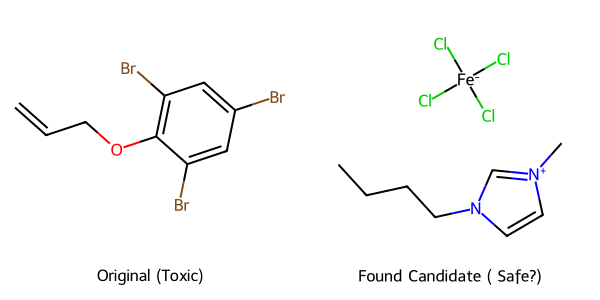

In [ ]:

# STEP 4: EUCLIDEAN REALISM CHECK & VISUALIZATION
from sklearn.neighbors import NearestNeighbors
from rdkit.Chem import Draw

# 1. SETUP SEARCH ENGINE (The "Haystack")
# We search against the entire database (or you could filter for only Safe ones)
database_vectors = pipeline.X_tensor.cpu().numpy()
knn = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='euclidean')
knn.fit(database_vectors)

# 2. QUERY THE AI RESULT (The "Needle")
target_vector = optimized_vector.cpu().numpy()
distances, indices = knn.kneighbors(target_vector)

best_idx = indices[0][0]
best_smiles = pipeline.smiles_db[best_idx]
best_dist = distances[0][0]

# 3. CONVERT NUMBERS BACK TO HUMAN UNITS
# We need to un-scale them to see "Weight: 400g" instead of "Weight: 1.2"
orig_real = pipeline.scaler.inverse_transform(original_features.cpu().numpy())[0]
ai_real   = pipeline.scaler.inverse_transform(target_vector)[0]
found_real= pipeline.scaler.inverse_transform(database_vectors[best_idx].reshape(1,-1))[0]

# 4. PRINT REPORT
print(f"SEARCH COMPLETE")
print(f"Original Toxic Molecule: {original_smiles}")
print(f"Closest Real Candidate:  {best_smiles}")
print(f"Euclidean Distance:      {best_dist:.4f}")

print("\n--- FEATURE CHANGE REPORT ---")
print(f"{'Feature':<20} | {'Original':<10} | {'AI Suggests':<12} | {'Real Match':<10}")
print("-" * 60)

# Highlights important changes
for i, name in enumerate(FEATURE_NAMES):
    val_orig = orig_real[i]
    val_ai   = ai_real[i]
    val_found= found_real[i]

    # Add a star * if the change was significant (>10%)
    diff = abs(val_orig - val_found)
    mark = "*" if diff > (abs(val_orig)*0.10) else ""

    print(f"{name:<20} | {val_orig:<10.2f} | {val_ai:<12.2f} | {val_found:<10.2f} {mark}")

# 5. DRAW THE MOLECULES
print("\n--- VISUAL COMPARISON ---")
mols = [Chem.MolFromSmiles(original_smiles), Chem.MolFromSmiles(best_smiles)]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300),
                           legends=["Original (Toxic)", "Found Candidate ( Safe?)"])
display(img)


 SEARCHING ZINC DATABASE...
-----------------------------------------------------------------
Original Toxic Molecule: C=CCOc1c(Br)cc(Br)cc1Br
Start Toxicity Score:    0.5454 
-----------------------------------------------------------------
ZINC Discovery:          CCN(Cc1ccc(I)cc1)C(F)(F)F
Euclidean Distance:      1.0805
Predicted Toxicity:      0.2853
-----------------------------------------------------------------

--- FEATURE CHANGE REPORT (ZINC MATCH) ---
Feature              | Original   | Model Suggests | ZINC Match
-----------------------------------------------------------------
MolWt                | 370.87     | 371.20       | 329.10     *
MolLogP              | 4.54       | 3.60         | 3.63       *
TPSA                 | 9.23       | 9.44         | 3.24       *
RingCount            | 1.00       | 1.04         | 1.00       
NumRotatableBonds    | 3.00       | 3.42         | 3.00       
NumHDonors           | 0.00       | -1.11        | 0.00       
NumHAcceptors        

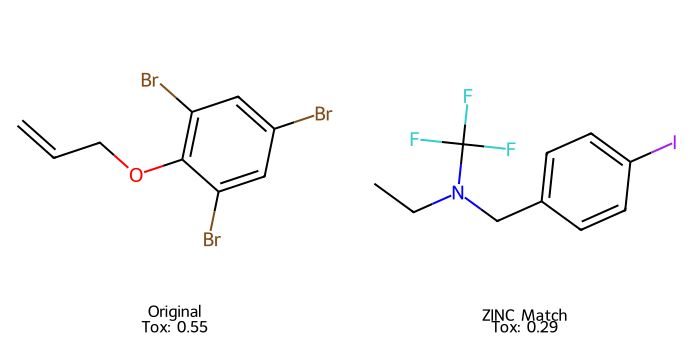

In [ ]:

# STEP 4.5: FULL ZINC-250k SEARCH & DETAILED REPORT
import requests
import io
import time
from sklearn.neighbors import NearestNeighbors
from rdkit.Chem import Draw

# 1. DOWNLOAD
if 1==2:
    print("Downloading ZINC-250k Dataset")
    url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
    response = requests.get(url)
    content = response.content.decode('utf-8')
    zinc_df = pd.read_csv(io.StringIO(content))
    # FULL DATASET
    N_ZINC = len(zinc_df)
    zinc_subset = zinc_df
    print(f"Loaded {len(zinc_subset)} molecules.")

    # 2. PROCESS (The long part)
    print("Processing ZINC features")
    start_time = time.time()
    zinc_feats = []
    zinc_smiles = []

    for i, smiles in enumerate(zinc_subset['smiles']):
        if i % 10000 == 0 and i > 0:
            elapsed = time.time() - start_time
            rate = i / elapsed
            print(f"   Processed {i}/{N_ZINC} ({rate:.1f} mols/sec)...")

        smi = smiles.strip()
        f = get_mol_descriptors(smi)
        if f is not None:
            zinc_feats.append(f)
            zinc_smiles.append(smi)

    # Convert & Scale
    zinc_X_raw = np.array(zinc_feats, dtype=np.float32)
    # CRITICAL: Use the pipeline scaler to match the training data universe
    zinc_X_scaled = pipeline.scaler.transform(zinc_X_raw)
    print(f"ZINC Processing Complete. Valid Molecules: {len(zinc_X_scaled)}")


# A. SEARCH
print("\n SEARCHING ZINC DATABASE...")
knn_zinc = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='euclidean')
knn_zinc.fit(zinc_X_scaled)

target_vector = optimized_vector.cpu().numpy()
dists_z, idxs_z = knn_zinc.kneighbors(target_vector)

best_idx_z = idxs_z[0][0]
best_smiles_z = zinc_smiles[best_idx_z]
best_dist_z = dists_z[0][0]


# B. VERIFY TOXICITY
best_match_tensor = torch.tensor(zinc_X_scaled[best_idx_z]).float().to(device).unsqueeze(0)
model.eval()
with torch.no_grad():
    zinc_pred_logits = model(best_match_tensor)
    zinc_pred_prob = torch.sigmoid(zinc_pred_logits).item()


# C. DETAILED TABLE
# Un-scale values for human readability
orig_real = pipeline.scaler.inverse_transform(original_features.cpu().numpy())[0]
ai_real   = pipeline.scaler.inverse_transform(target_vector)[0]
# Get the ZINC match features un-scaled
zinc_real = pipeline.scaler.inverse_transform(zinc_X_scaled[best_idx_z].reshape(1,-1))[0]

print("-" * 65)
print(f"Original Toxic Molecule: {original_smiles}")
print(f"Start Toxicity Score:    {initial_pred:.4f} ")
print("-" * 65)
print(f"ZINC Discovery:          {best_smiles_z}")
print(f"Euclidean Distance:      {best_dist_z:.4f}")
print(f"Predicted Toxicity:      {zinc_pred_prob:.4f}")
print("-" * 65)

print("\n--- FEATURE CHANGE REPORT (ZINC MATCH) ---")
print(f"{'Feature':<20} | {'Original':<10} | {'Model Suggests':<12} | {'ZINC Match':<10}")
print("-" * 65)

for i, name in enumerate(FEATURE_NAMES):
    val_orig = orig_real[i]
    val_ai   = ai_real[i]
    val_found= zinc_real[i]

    # Add a star * if the ZINC match is significantly different from Original
    # This highlights where the "Invention" happened
    diff = abs(val_orig - val_found)
    mark = "*" if diff > (abs(val_orig)*0.10) else ""

    print(f"{name:<20} | {val_orig:<10.2f} | {val_ai:<12.2f} | {val_found:<10.2f} {mark}")


# D. VISUALIZE
print("\n--- ZINC DISCOVERY VS TOXIC ORIGINAL ---")
mols_z = [Chem.MolFromSmiles(original_smiles), Chem.MolFromSmiles(best_smiles_z)]
legends = [
    f"Original\nTox: {initial_pred:.2f}",
    f"ZINC Match\nTox: {zinc_pred_prob:.2f}"
]
img_z = Draw.MolsToGridImage(mols_z, molsPerRow=2, subImgSize=(350, 350), legends=legends)
display(img_z)

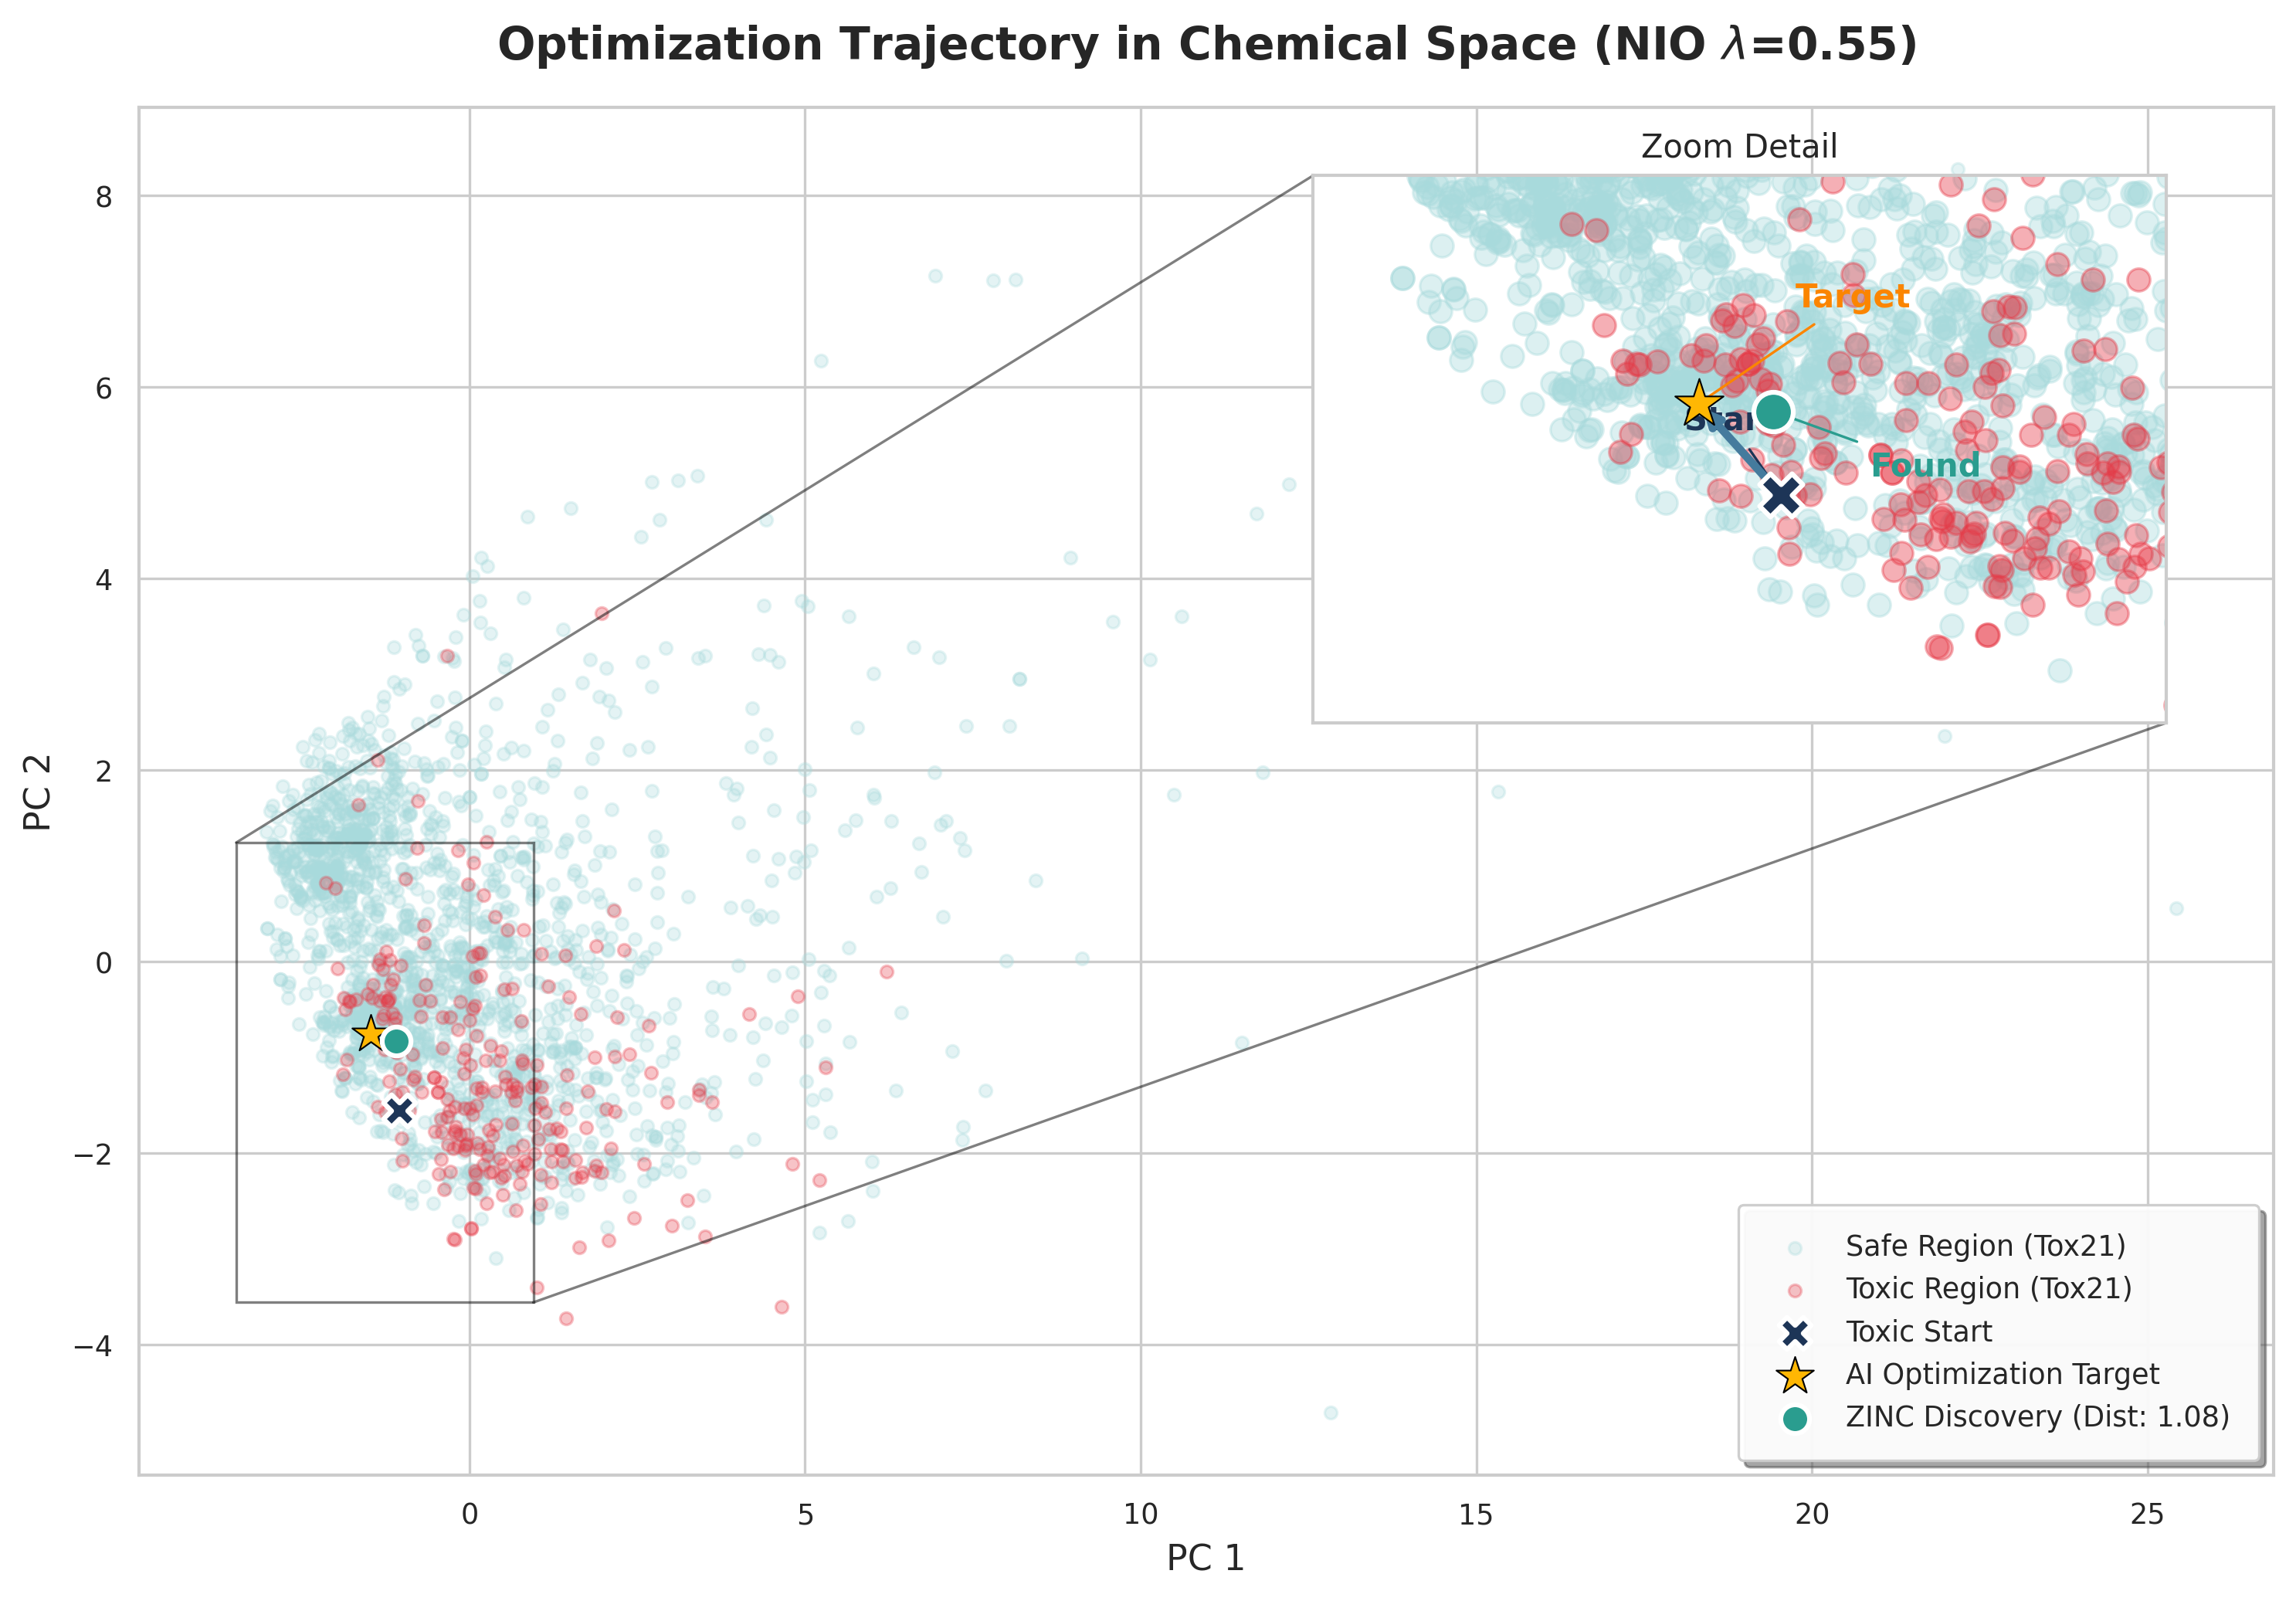

In [ ]:
# STEP 5: FINAL OPTIMIZATION TRAJECTORY PLOT
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np


# CONFIGURATION
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 300


# DATA PREP
# 1. Background Map
sample_indices = np.random.choice(len(pipeline.X_scaled), 2000, replace=False)
X_sample = pipeline.X_scaled[sample_indices]
y_sample = pipeline.y_tensor[sample_indices].cpu().numpy().flatten()

# 2. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# 3. Transform Key Points
start_pca = pca.transform(original_features.cpu().numpy())
end_pca   = pca.transform(target_vector.reshape(1, -1))
zinc_match_vector = zinc_X_scaled[best_idx_z].reshape(1, -1)
found_pca = pca.transform(zinc_match_vector)


# PLOTTING
fig, ax = plt.subplots(figsize=(10, 7))

# --- MAIN PLOT (Global View) ---
# 1. Background
ax.scatter(X_pca[y_sample==0, 0], X_pca[y_sample==0, 1],
           c='#a8dadc', alpha=0.3, s=15, label='Safe Region (Tox21)', rasterized=True)
ax.scatter(X_pca[y_sample==1, 0], X_pca[y_sample==1, 1],
           c='#e63946', alpha=0.3, s=15, label='Toxic Region (Tox21)', rasterized=True)

# 2. Key Players (Main Axis for Legend visibility)
ax.scatter(start_pca[0,0], start_pca[0,1], c='#1d3557', s=100, marker='X',
           edgecolors='white', linewidth=1.5, label='Toxic Start', zorder=5)

ax.scatter(end_pca[0,0], end_pca[0,1], c='#ffb703', s=150, marker='*',
           edgecolors='black', linewidth=0.5, label='AI Optimization Target', zorder=5)

ax.scatter(found_pca[0,0], found_pca[0,1], c='#2a9d8f', s=80, marker='o',
           edgecolors='white', linewidth=1.5, label=f'ZINC Discovery (Dist: {best_dist_z:.2f})', zorder=5)

# 3. Titles & Legend
ax.set_title(f"Optimization Trajectory in Chemical Space (NIO $\lambda$={LAMBDA_REG})",
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("PC 1", fontsize=11)
ax.set_ylabel("PC 2", fontsize=11)

# Legend at bottom right (usually safe from top-right inset)
ax.legend(loc='lower right', frameon=True, fancybox=True, framealpha=0.95, shadow=True, borderpad=1)


# --- INSET PLOT (Top Right Position) ---
# [x, y, width, height] relative to axes
ax_ins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])

# Re-plot Background inside Zoom
ax_ins.scatter(X_pca[y_sample==0, 0], X_pca[y_sample==0, 1], c='#a8dadc', alpha=0.4, s=50)
ax_ins.scatter(X_pca[y_sample==1, 0], X_pca[y_sample==1, 1], c='#e63946', alpha=0.4, s=50)

# Re-plot Key Players inside Zoom
ax_ins.scatter(start_pca[0,0], start_pca[0,1], c='#1d3557', s=180, marker='X',
               edgecolors='white', linewidth=1.5, zorder=10)
ax_ins.scatter(end_pca[0,0], end_pca[0,1], c='#ffb703', s=250, marker='*',
               edgecolors='black', linewidth=0.5, zorder=10)
ax_ins.scatter(found_pca[0,0], found_pca[0,1], c='#2a9d8f', s=150, marker='o',
               edgecolors='white', linewidth=1.5, zorder=10)

# Arrow inside Zoom
ax_ins.annotate("",
                xy=(end_pca[0,0], end_pca[0,1]),
                xytext=(start_pca[0,0], start_pca[0,1]),
                arrowprops=dict(arrowstyle="->", color="#457b9d", lw=2.5),
                zorder=9)

# --- TEXT LABELS (Offset to prevent overlap) ---
# Start Label
ax_ins.annotate('Start', xy=(start_pca[0,0], start_pca[0,1]),
                xytext=(-30, 20), textcoords='offset points',
                fontsize=10, fontweight='bold', color='#1d3557',
                arrowprops=dict(arrowstyle="-", color='#1d3557'))

# Found Label
ax_ins.annotate('Found', xy=(found_pca[0,0], found_pca[0,1]),
                xytext=(30, -20), textcoords='offset points',
                fontsize=10, fontweight='bold', color='#2a9d8f',
                arrowprops=dict(arrowstyle="-", color='#2a9d8f'))

# Target Label
ax_ins.annotate('Target', xy=(end_pca[0,0], end_pca[0,1]),
                xytext=(30, 30), textcoords='offset points',
                fontsize=10, fontweight='bold', color='#fb8500',
                arrowprops=dict(arrowstyle="-", color='#fb8500'))

# --- CONNECT ZOOM BOX ---
# Auto-scale zoom box limits with padding
padding = 2.0
x_pts = [start_pca[0,0], end_pca[0,0], found_pca[0,0]]
y_pts = [start_pca[0,1], end_pca[0,1], found_pca[0,1]]
ax_ins.set_xlim(min(x_pts)-padding, max(x_pts)+padding)
ax_ins.set_ylim(min(y_pts)-padding, max(y_pts)+padding)

# Clean up inset ticks
ax_ins.set_xticks([])
ax_ins.set_yticks([])
ax_ins.set_title("Zoom Detail", fontsize=10)

# Draw connector lines
ax.indicate_inset_zoom(ax_ins, edgecolor="black", alpha=0.5)

plt.tight_layout()
plt.show()